In [1]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Subtracting mean and normalizing to save pictures

images_pot        = glob(os.path.join("/home/mikkel/Documents/github/BSc-PRO/Classification/res_still/train/potato", "*.jpg"))
images_cat        = glob(os.path.join("/home/mikkel/Documents/github/BSc-PRO/Classification/res_still/train/catfood", "*.jpg"))
images_tab        = glob(os.path.join("/home/mikkel/Documents/github/BSc-PRO/Classification/res_still/train/table", "*.jpg"))

X_train = ii.images_import(images_pot, images_cat, images_tab)

mean_image, train_pot = ii.make_images_mean(X_train, "res_still", "res_still_mean")


In [2]:
train_path = 'res_still/train'
valid_path = 'res_still/valid'
test_path = 'res_still/test'

train_path_mean = 'res_still_mean/train'
valid_path_mean = 'res_still_mean/valid'
test_path_mean = 'res_still_mean/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        featurewise_center=True,
        #featurewise_std_normalization=True
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35)
)

valid_datagen = ImageDataGenerator(
        featurewise_center=True, 
        #featurewise_std_normalization=True
        rescale=1./255
)

num_classes = 3

train_pot = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/train/potato", "*.jpg"))
train_cat = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/train/catfood", "*.jpg"))
train_tab = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/train/table", "*.jpg"))
val_pot   = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/valid/potato", "*.jpg"))
val_cat   = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/valid/catfood", "*.jpg"))
val_tab   = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/valid/table", "*.jpg"))
test_pot  = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/test/potato", "*.jpg"))
test_cat  = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/test/catfood", "*.jpg"))
test_tab  = glob(os.path.join("/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/Classification/res_still/test/table", "*.jpg"))

X_train, y_train = ii.images_to_numpy(train_pot, train_cat, train_tab)
X_val, y_val = ii.images_to_numpy(val_pot, val_cat, val_tab)
X_test, y_test = ii.images_to_numpy(test_pot, test_cat, test_tab)

X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

#X_train /= 255.
#X_val /= 255.
#X_test /= 255.

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

train_datagen.fit(X_train/255)
valid_datagen.fit(X_train/255)


train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

validation_generator = valid_datagen.flow(X_val,
                                     y_val,
                                     batch_size=batch_size, shuffle=True)
img, label = next(train_generator)
print(label)

#
## Train data generator
#train_generator = train_datagen.flow_from_directory(
#        train_path,
#        target_size=(224, 224),
#        batch_size=batch_size,
#        classes=['potato', 'catfood', 'table'])
#
## Validation data generator
#validation_generator = valid_datagen.flow_from_directory(
#        valid_path,
#        target_size=(224, 224),
#        batch_size=batch_size,
#        classes=['potato', 'catfood', 'table'])
#
## this is a similar generator, for validation data
#test_generator = valid_datagen.flow_from_directory(
#        test_path,
#        target_size=(224, 224),
#        batch_size=batch_size,
#        classes=['potato', 'catfood', 'table'])

[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [3]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
# kernel_regularizer: Regularizer function applied to the kernel weights matrix (see regularizer).
model.add(Dense(128 ,kernel_regularizer=regularizers.l2(0.0002)))
#model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3, kernel_regularizer=regularizers.l2(0.0002)))
#model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=0.0),
              #optimizer=SGD(lr=0.1, decay=0.25),
              metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               19267712  
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 19,268,099
Trainable params: 19,268,099
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=384 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=100 // batch_size)

Epoch 1/100
12/12 [==============================] - 6s 508ms/step - loss: 2.8618 - acc: 0.3740 - val_loss: 1.3779 - val_acc: 0.3854
Epoch 2/100
12/12 [==============================] - 5s 451ms/step - loss: 1.5462 - acc: 0.4504 - val_loss: 1.2079 - val_acc: 0.3235
Epoch 3/100
12/12 [==============================] - 5s 448ms/step - loss: 1.3947 - acc: 0.4527 - val_loss: 1.1198 - val_acc: 0.3676
Epoch 4/100
12/12 [==============================] - 5s 447ms/step - loss: 1.3739 - acc: 0.5077 - val_loss: 1.0869 - val_acc: 0.3676
Epoch 5/100
12/12 [==============================] - 5s 449ms/step - loss: 1.2633 - acc: 0.5313 - val_loss: 0.9696 - val_acc: 0.4167
Epoch 6/100
12/12 [==============================] - 5s 450ms/step - loss: 1.1313 - acc: 0.5103 - val_loss: 1.0161 - val_acc: 0.3676
Epoch 7/100
12/12 [==============================] - 5s 455ms/step - loss: 1.1148 - acc: 0.5028 - val_loss: 0.9343 - val_acc: 0.5294
Epoch 8/100
12/12 [==============================] - 6s 475ms/step - 

12/12 [==============================] - 6s 477ms/step - loss: 0.4129 - acc: 0.8693 - val_loss: 0.1872 - val_acc: 0.9853
Epoch 63/100
12/12 [==============================] - 6s 471ms/step - loss: 0.3094 - acc: 0.9135 - val_loss: 0.1477 - val_acc: 1.0000
Epoch 64/100
12/12 [==============================] - 6s 484ms/step - loss: 0.2577 - acc: 0.9319 - val_loss: 0.1644 - val_acc: 0.9853
Epoch 65/100
12/12 [==============================] - 5s 454ms/step - loss: 0.2430 - acc: 0.9345 - val_loss: 0.1612 - val_acc: 0.9896
Epoch 66/100
12/12 [==============================] - 6s 466ms/step - loss: 0.2883 - acc: 0.9266 - val_loss: 0.1533 - val_acc: 0.9853
Epoch 67/100
12/12 [==============================] - 5s 457ms/step - loss: 0.2494 - acc: 0.9502 - val_loss: 0.1904 - val_acc: 0.9559
Epoch 68/100
12/12 [==============================] - 5s 456ms/step - loss: 0.2286 - acc: 0.9502 - val_loss: 0.1637 - val_acc: 0.9706
Epoch 69/100
12/12 [==============================] - 6s 459ms/step - loss:

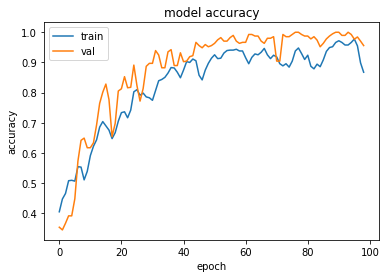

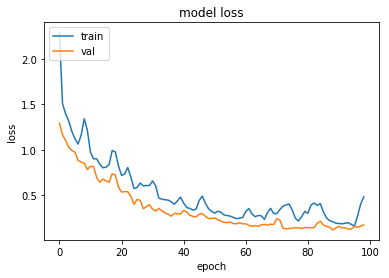

In [5]:
plot_history(history, mean_N=2)

In [6]:
imgs, labels = next(validation_generator)
img = Image.fromarray(imgs[1].astype('uint8'), 'RGB')
#img.show()

#ynew = model.predict(imgs)


model.evaluate(imgs,labels, batch_size=batch_size)

32/32 [==============================] - 0s 2ms/step


[0.12872758507728577, 1.0]

In [7]:
imgs, labels = next(validation_generator)
model.predict(imgs)
#print(imgs)

array([[1.3092266e-02, 2.5478655e-02, 9.6142906e-01],
       [7.2406144e-03, 1.0651035e-02, 9.8210835e-01],
       [9.9922991e-01, 7.6800765e-04, 2.1258959e-06],
       [5.3404361e-02, 9.4550073e-01, 1.0949062e-03],
       [2.5073400e-01, 7.4918997e-01, 7.6096323e-05],
       [1.8035164e-02, 4.1818574e-02, 9.4014621e-01],
       [9.8170817e-01, 1.8274760e-02, 1.7028222e-05],
       [5.2834939e-02, 9.4342685e-01, 3.7381994e-03],
       [9.2331779e-01, 7.6654106e-02, 2.8034785e-05],
       [9.1258210e-01, 8.7236576e-02, 1.8131213e-04],
       [5.3478248e-02, 9.4560665e-01, 9.1513421e-04],
       [1.9276846e-02, 2.9570553e-02, 9.5115262e-01],
       [1.5978669e-01, 8.3975768e-01, 4.5564334e-04],
       [7.6226717e-01, 2.3772711e-01, 5.7668612e-06],
       [9.9237692e-01, 7.5400462e-03, 8.3059116e-05],
       [9.9883801e-01, 1.1419827e-03, 2.0037547e-05],
       [9.6247590e-01, 3.7463356e-02, 6.0687769e-05],
       [1.1247259e-02, 3.4160685e-02, 9.5459211e-01],
       [5.8259196e-03, 1.147

In [8]:
img[0]

TypeError: 'Image' object does not support indexing